Imports

In [82]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim


## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file

%matplotlib inline

Setting up the Raster Model 

In [83]:
#Set grid parameters
num_rows = 50
num_columns = 50
node_spacing = 100.00

#Set Model Time Parameters
timestep = 1.0
run_time = 10 #years

uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')

#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)

#topographic roughness
#random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid


#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation'
mg.at_node["bedrock__elevation"] += (mg.node_y / 10. + mg.node_x / 10. + np.random.rand(len(mg.node_y)) / 10.0)

mg.at_node["topographic__elevation"][:] = mg.at_node["bedrock__elevation"]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]



Setting Boundary Conditions of the Model Grid

In [84]:
#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)


Instantiate the Components

In [85]:
#Parameters for SPACE and Fastscape
K_sed = 0.01
K_sp = 0.001
K_br = 0.001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8') 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)  

#Instantiate SPACE model with chosen parameters as sp
sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)



remember: need to run fascape-- probably for like 100 years to create the initial topography until it reaches the steady state 

also need to create a function to fine where to start collecting the sed_flux values

Using Fastspace Bring the Model to steady state

In [98]:
#run for 10 years
for x in range(10000):
    #mg.at_node['bedrock__elevation'][:] += uplift_per_timestep  #adding uplift to the bedrock
    #mg.at_node['topographic__elevation'][:]= mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift
    mg.at_node["topographic__elevation"][0] -= 0.001 # Uplift
    mg.at_node["bedrock__elevation"][0] -= 0.001 # Uplift

    fa.run_one_step()
    df.map_depressions()
    fsc.run_one_step(100)
    



Show the Topographic Elevation

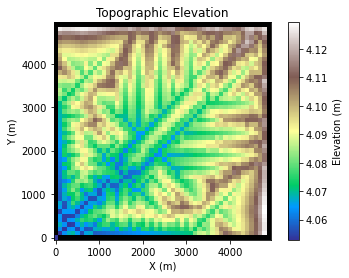

In [99]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

Run the Model

In [102]:
#Set elapsed time to zero
elapsed_time = 0

#Set timestep count to zero
count = 0

#Array to save sediment flux values and is currently filled with 0s
sed_flux = [0] * (run_time) 

#This will iterate through all of the years needed and will essentially run the model
while elapsed_time < run_time: #time units of years
    mg.at_node['bedrock__elevation'] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift

    fa.run_one_step()
    sp.run_one_step(dt = timestep)
    sed_flux[count] = mg.at_node["sediment__flux"][51]

    elapsed_time += timestep
    print(count)
    count +=1
    
    

0
1
2
3
4
5
6
7
8
9


Create Primary Channel Profile

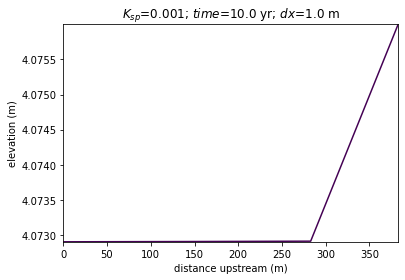

In [103]:
prf = ChannelProfiler(mg,
                      number_of_watersheds=1,
                      main_channel_only=True,
                      minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

#Show the profile
plt.figure(1)
title_text = f"$K_{{sp}}$={.001}; $time$={elapsed_time} yr; $dx$={timestep} m"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)',
                  title=title_text)

Text(0, 0.5, 'Sediment flux [m$^3$/yr]')

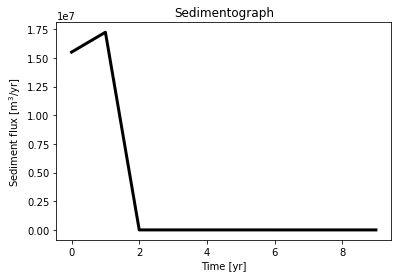

In [104]:
#Instantiate figure as an empty plot
fig = plt.figure()

#Instantiate subplot as an empty plot
sedfluxplot = plt.subplot()

#Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

#Add axis labels to the plot 
sedfluxplot.set_title('Sedimentograph') #title
sedfluxplot.set_xlabel('Time [yr]') #x axis label
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label